# Disability at six month follow up

## Aims

Investigating factors that relate to:
* Whether patients have a record of disability at six months
* Patients disability score/change in disability between discharge and follow up

This analysis uses the dataset of people who arrived within four hours of known stroke onset.

## Set up

In [1]:
# Import packages and functions
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# Set max rows when display dataframe
pd.set_option('display.max_rows', 100)

# Linting
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
# Set paths and filenames
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and files.'''

    data_path = './../output/'
    data_filename = 'reformatted_data.csv'


paths = Paths()

In [3]:
# Load data
data = pd.read_csv(os.path.join(paths.data_path,
                                paths.data_filename))

## Descriptive

### Completion

* 28.6% complete data
* 70.7% missing disability at 6 months
* 0.7% missing discharge disability and disability at 6 months.

Data on disability at 6-month follow-up is NOT missing at random.

In [4]:
disability_completion = (
    data[['prior_disability', 'discharge_disability', 'disability_6_month']]
    .isnull()
    .apply(lambda x: x.map({True: 'Missing', False: 'Not missing'}))
    .value_counts()
    .reset_index(name='count')
    .sort_values(by='disability_6_month', ascending=False))
disability_completion['proportion'] = (
    disability_completion['count'] / disability_completion['count'].sum())
disability_completion

,prior_disability,discharge_disability,disability_6_month,count,proportion
1,Not missing,Not missing,Not missing,39167,0.285851
0,Not missing,Not missing,Missing,96845,0.706800
2,Not missing,Missing,Missing,1007,0.007349


### Comparing patients followed up with those not

Average stroke severity of patients seen for 6 month follow up is milder than those not seen (7.0 v.s. 9.7).

In [5]:
# Group by whether disability at 6 months is known and compare stroke severity
data['disability_6_month_known'] = (
    data['disability_6_month']
    .isnull()
    .map({True: 'No (missing)', False: 'Yes (present)'}))

data.groupby('disability_6_month_known')['stroke_severity'].describe()

,count,mean,std,min,25%,50%,75%,max
disability_6_month_known,,,,,,,,
No (missing),97852.0,9.689889,8.756325,0.0,3.0,6.0,15.0,42.0
Yes (present),39167.0,6.995940,6.499562,0.0,2.0,5.0,10.0,42.0


A higher proportion of thrombolysed patients have a 6-month-follow-up than non-thrombolysed (31.3% v.s. 27.5%).

In [6]:
(data
 .groupby('thrombolysis')['disability_6_month_known']
 .value_counts(normalize=True))

thrombolysis  disability_6_month_known
0             No (missing)                0.725331
              Yes (present)               0.274669
1             No (missing)                0.687080
              Yes (present)               0.312920
Name: disability_6_month_known, dtype: float64

### Disability at 6 month follow up

**Change in disability**

We received a comment that we expect people to, on average, be 1 unit better.

We see that Rankin score from discharge to follow-up is, on average, the same (median) or worse (mean) (focussing only on people who have measurements at both time points).

Caveats include:
* mRS is an ordinal scale (i.e. they have an order but there is not a consistent space on the scale between each score) (hence why some of the other analyses on SAMueL2 use utility values)

In [7]:
# Change in mRS score from discharge to 6 months later
mrs_6m = ((data['disability_6_month'] - data['discharge_disability'])
          .dropna().describe())

print(f'''From discharge to 6 months later, the mean change in
Modified Rankin Scale score is {mrs_6m.squeeze()['mean']:.1f}

Description of change in scores...''')
display(mrs_6m)

From discharge to 6 months later, the mean change in
Modified Rankin Scale score is 0.1

Description of change in scores...


count    39167.000000
mean         0.101182
std          1.516493
min         -5.000000
25%         -1.000000
50%          0.000000
75%          1.000000
max          6.000000
dtype: float64

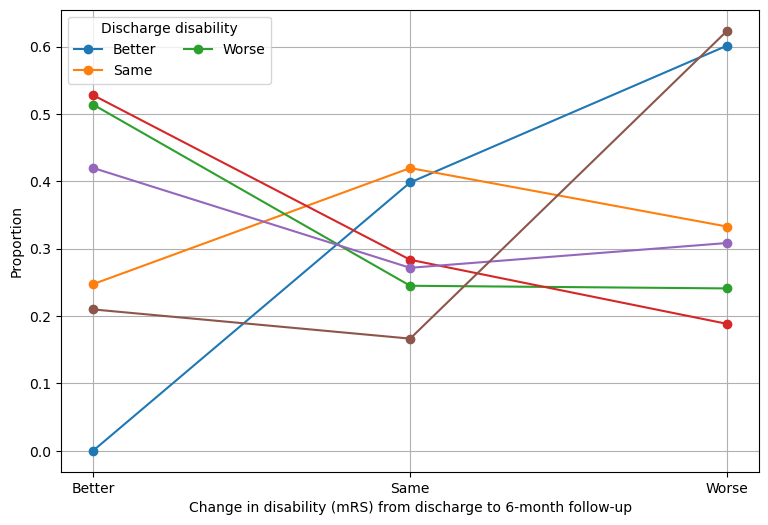

In [8]:
# Extract individuals with complete data at followup
mrs_compare = (data[['disability_6_month', 'discharge_disability']]
               .dropna()
               .rename(columns={'disability_6_month': 'followup',
                                'discharge_disability': 'discharge'}))

# Compare 6 month disability to discharge disability
mrs_compare['compare'] = np.where(
    mrs_compare['followup'] > mrs_compare['discharge'], 'Worse', np.where(
        mrs_compare['followup'] < mrs_compare['discharge'], 'Better', 'Same'
    ))

# Find proportion better, same or worse - by discharge disability
mrs_compare_3 = (
    mrs_compare.groupby('discharge')['compare']
    .value_counts(normalize=True)
    .reset_index(name='prop')
    .sort_values(by=['discharge', 'compare'])
    .pivot(index='discharge',
           columns='compare',
           values='prop')
    .fillna(0))

# Plot those proportions
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(mrs_compare_3.T, marker='o')
ax.set_xlabel('Change in disability (mRS) from discharge to 6-month follow-up')
ax.set_ylabel('Proportion')
ax.legend(ax.get_lines(), mrs_compare_3.columns, loc='best',
          title='Discharge disability', ncol=2)
ax.grid()
plt.show()

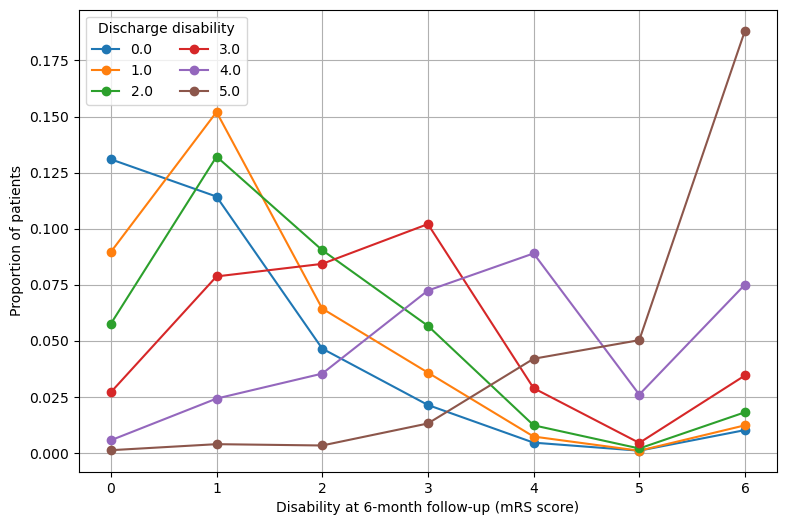

In [9]:
# Find proportion with each disability at 6 months,
# grouped by discharge disability
followup = (data
            .groupby('discharge_disability')['disability_6_month']
            .value_counts(normalize=True, dropna=False)
            .reset_index(name='prop')
            .sort_values(by=['discharge_disability', 'disability_6_month']))

# Pivot those results so they're suitable for plot
followup_p = (followup
              .dropna()
              .pivot(columns='disability_6_month',
                     index='discharge_disability',
                     values='prop'))

# Create plot (line plot as easier to see difference in proportions)
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(followup_p.T, marker='o')
ax.set_xlabel('Disability at 6-month follow-up (mRS score)')
ax.set_ylabel('Proportion of patients')
ax.legend(ax.get_lines(), followup_p.columns, loc='best',
          title='Discharge disability', ncol=2)
ax.grid()
plt.show()